In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import psycopg2
import pandas.io.sql as psql
import datetime
from datetime import date

In [3]:
data = pd.read_csv('bus_line.csv')

In [5]:
data = data.drop('Unnamed: 0', axis=1)

In [7]:
data.head(3)

,s_mac_address,s_ssid,s_created_at,s_rssi,s_sensor_id,date
0,cf4cfaa9b70a52bbfbaa5b52846547e8ee4d5a5885ef92...,NaN,2016-07-02 15:10:11,-79,1,2016-07-02
1,645491814dfdc193ed47537317b16bfd5c54b20ca12fa6...,iPhone,2016-07-02 15:10:11,-87,1,2016-07-02
2,645491814dfdc193ed47537317b16bfd5c54b20ca12fa6...,KTWF,2016-07-02 15:10:11,-87,1,2016-07-02


In [8]:
data.shape

(315039, 6)

In [48]:
data = data.fillna('')
data['s_created_at'] = pd.to_datetime(data['s_created_at'])

### RSSI値に応じて検出範囲を絞る（一般的には「-25 ~ -80」位が利用されている）、この条件を変更することで推定人数が変動する 

In [63]:
data = data[(data['s_rssi'] <= -25) & (data['s_rssi'] >= -80)]

## sensor_id と設置場所を紐付ける 

In [64]:
location_list = pd.DataFrame(
    {'s_sensor_id':[1, 2, 3, 4, 1, 2, 3, 4],
     'date': ['2016-06-25', '2016-06-25', '2016-06-25', '2016-06-25', '2016-07-02', '2016-07-02', '2016-07-02', '2016-07-02'],
     'location_name': ['バス停慶応大学前', 'バス停慶応大学本館前', 'バス停慶応大学前-SFC', 'Subway', 'バス停慶応大学前', '広場', 'バス停慶応大学前-SFC', 'Subway']}
)

In [65]:
data_with_location = pd.merge(data, location_list, left_on=['s_sensor_id', 'date'], right_on=['s_sensor_id', 'date'], how='inner')

## 分析例: 七夕祭時の各バス行列人数を推定する 

## 時刻表データをロードする 

In [66]:
time_table = pd.read_csv('bus_timetable.csv')

In [67]:
time_table.head(3)

,dep_time,dest,type,seat_num,max_num
0,7:00,shonandai,TwinLiner,45,100
1,7:05,shonandai,detour,28,56
2,7:15,shonandai,TwinLiner,45,100


## 湘南台行きの行列を推定するため、フィルタリングする 

In [68]:
time_table = time_table[time_table['dest'] == 'shonandai'].reset_index(drop=True)

In [69]:
time_table['dep_time'] = pd.to_datetime(time_table['dep_time'])

## 七夕祭当日かつバス停前のセンサデータを抽出する。またSSIDがbroadcastのデータは人々が持つ端末から放出された可能性が最も高いため、 SSIDが空のデータを抽出する

In [70]:
bus_line = data_with_location[(data_with_location['s_sensor_id'] == 1) & (data_with_location["s_ssid"] == '') & (data_with_location['date'] == '2016-07-02')]
bus_line = bus_line.reset_index(drop=True)

In [71]:
bus_line.shape

(16070, 7)

### 乗車予定バスの出発時間を追加する 

In [72]:
global t
t = time_table
def add_bus_interval(d):
    for i in range(len(t)):
        if i < t.shape[0] - 1:
            start = t['dep_time'].ix[i].time()
            end = t['dep_time'].ix[i+1].time()

            if start <= d.time() and end  >= d.time():
                return t['dep_time'].ix[i+1]
        else:
            return None
bus_line['ride_bus_time'] = bus_line['s_created_at'].apply(add_bus_interval)

In [73]:
bus_line.head(3)

,s_mac_address,s_ssid,s_created_at,s_rssi,s_sensor_id,date,location_name,ride_bus_time
0,cf4cfaa9b70a52bbfbaa5b52846547e8ee4d5a5885ef92...,,2016-07-02 15:10:11,-79,1,2016-07-02,バス停慶応大学前,2016-07-30 15:11:00
1,046e85dae9a11d22917df992b341db3e1513f25f8d2bbc...,,2016-07-02 15:10:19,-73,1,2016-07-02,バス停慶応大学前,2016-07-30 15:11:00
2,046e85dae9a11d22917df992b341db3e1513f25f8d2bbc...,,2016-07-02 15:10:19,-75,1,2016-07-02,バス停慶応大学前,2016-07-30 15:11:00


In [74]:
mobile_list = bus_line.groupby(['s_mac_address', 'ride_bus_time']).count().reset_index()
bus_count = mobile_list.groupby(['ride_bus_time']).count().reset_index()

bus_count2 = bus_count[['ride_bus_time', 's_mac_address']]
bus_count2.columns = ['dep_time', 'count']

In [83]:
bus_count2.head(3)

,dep_time,count
0,2016-07-30 10:00:00,18
1,2016-07-30 10:10:00,4
2,2016-07-30 10:23:00,9


In [87]:
def add_time(t):
    return t.time()
bus_count2['time'] = bus_count2['dep_time'].apply(add_time)

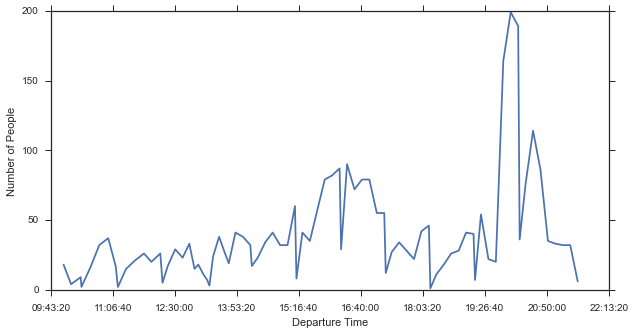

In [92]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.set(style="ticks")

plt.ylabel('Number of People')
plt.xlabel('Departure Time')
plt.plot(bus_count2["time"], bus_count2["count"])